In [1]:
import scanpy as sc
import matplotlib as mpl

In [2]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

In [3]:
adata = sc.read("./anndata_celltypist_anno.h5ad")
adata

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 172066 × 2000
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'lei

In [8]:
adata.var_names_make_unique()

In [9]:
# rcParams['figure.figsize'] = 4, 4

In [11]:
# adata.obs["celltypist_cell_label_coarse"] = pd.Categorical(
#     adata.obs["celltypist_cell_label_coarse"]
# )
group_by = "celltypist_cell_label_coarse"

sc.tl.rank_genes_groups(
    adata,
    groupby=group_by,
    method="t-test",
    use_raw=False,
    layer="scran_normalization",
)

ranking genes
    consider 'celltypist_cell_label_coarse' groups:
    with sizes: [  8008   1927  18660   5947   1948   3081  29362 102528    605]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


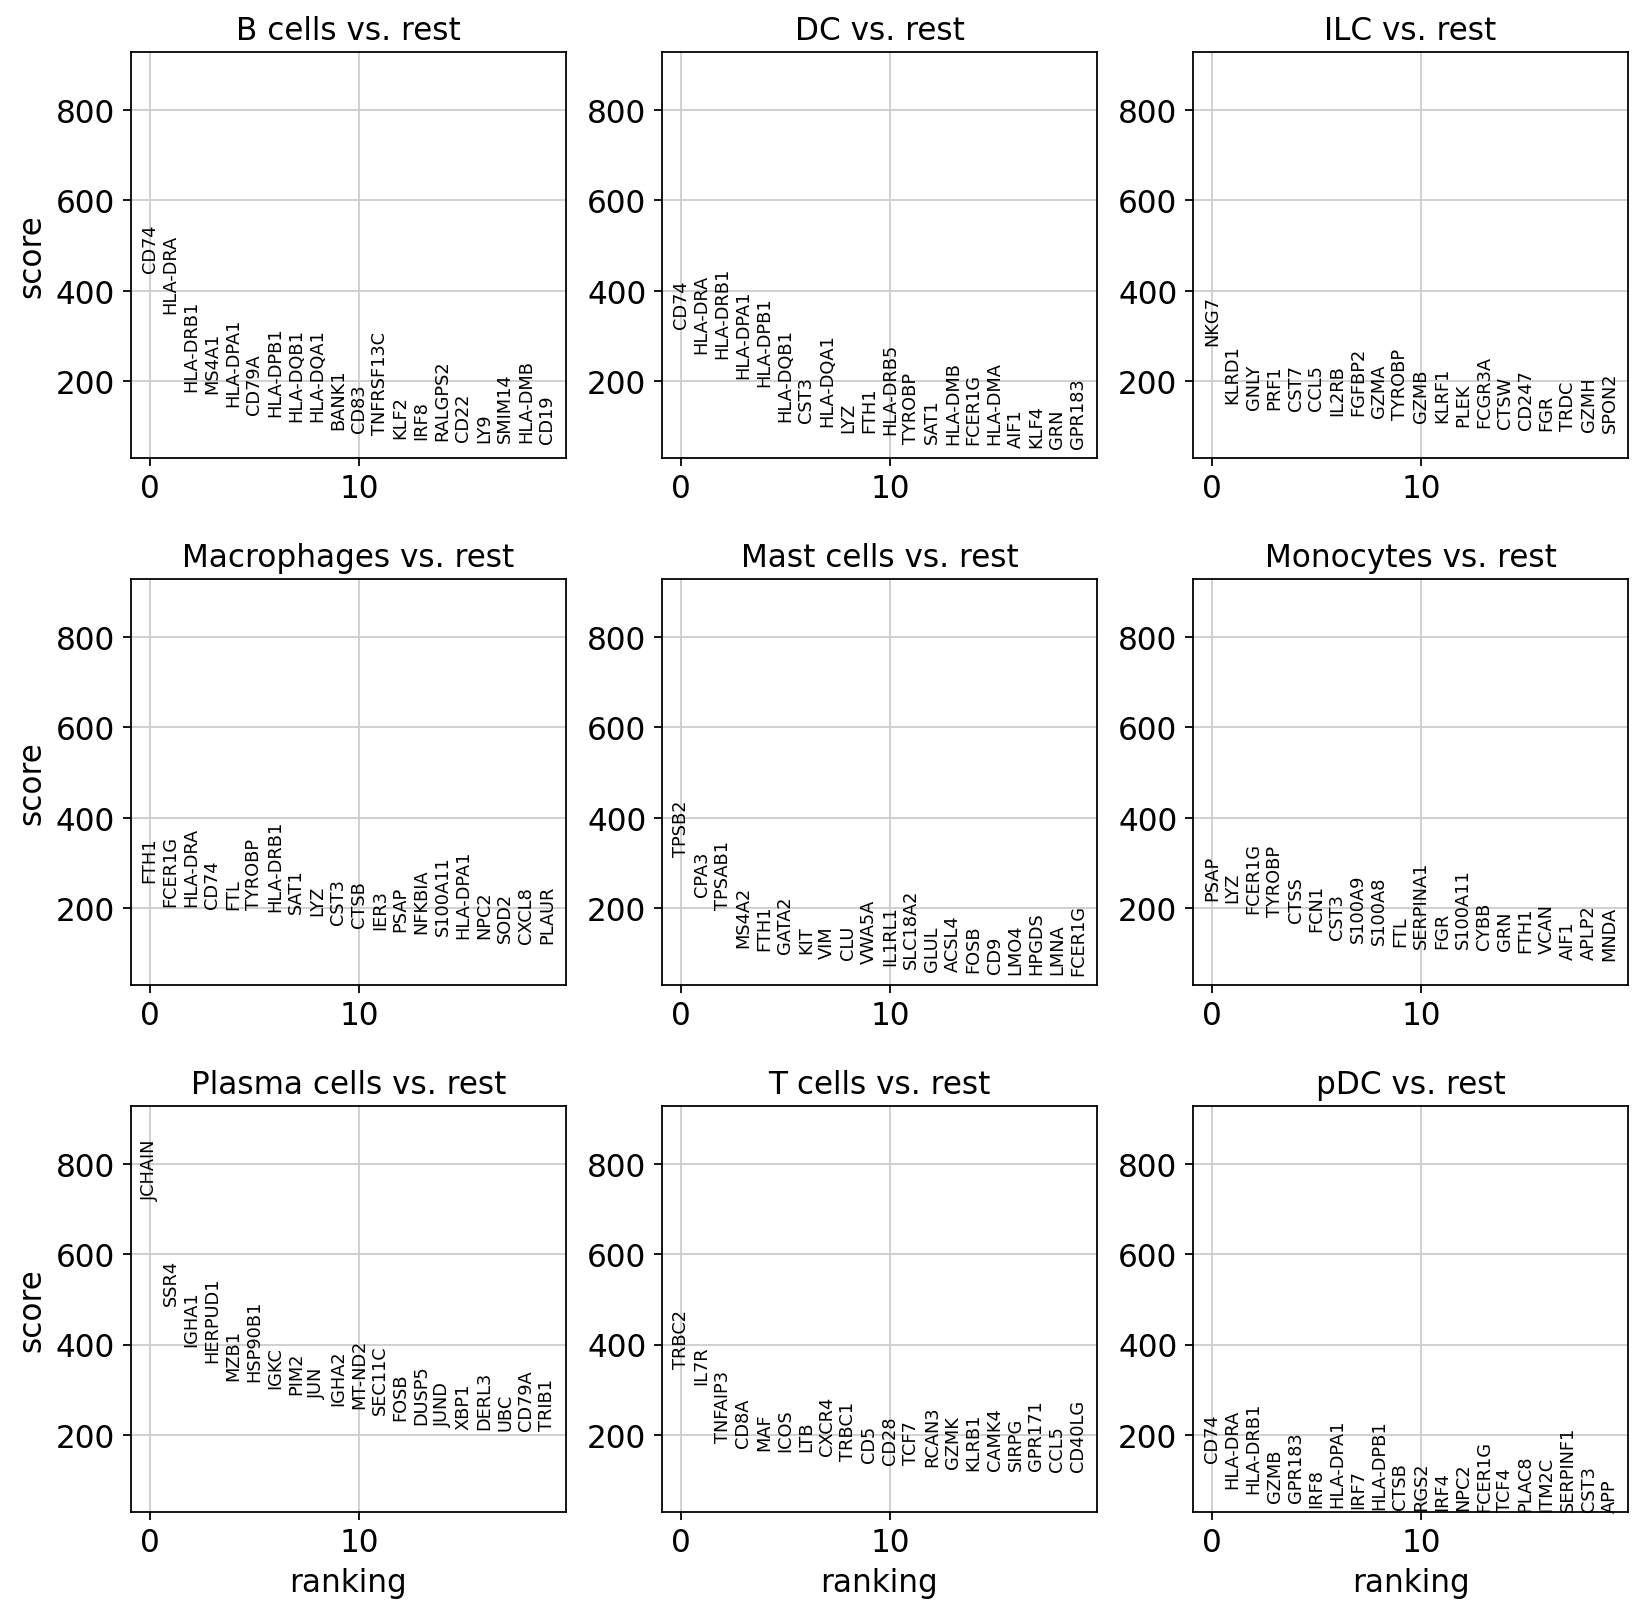

In [12]:
sc.pl.rank_genes_groups(adata, ncols=3)

    using 'X_pca' with n_pcs = 10
Storing dendrogram info using `.uns['dendrogram_celltypist_cell_label_coarse']`


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


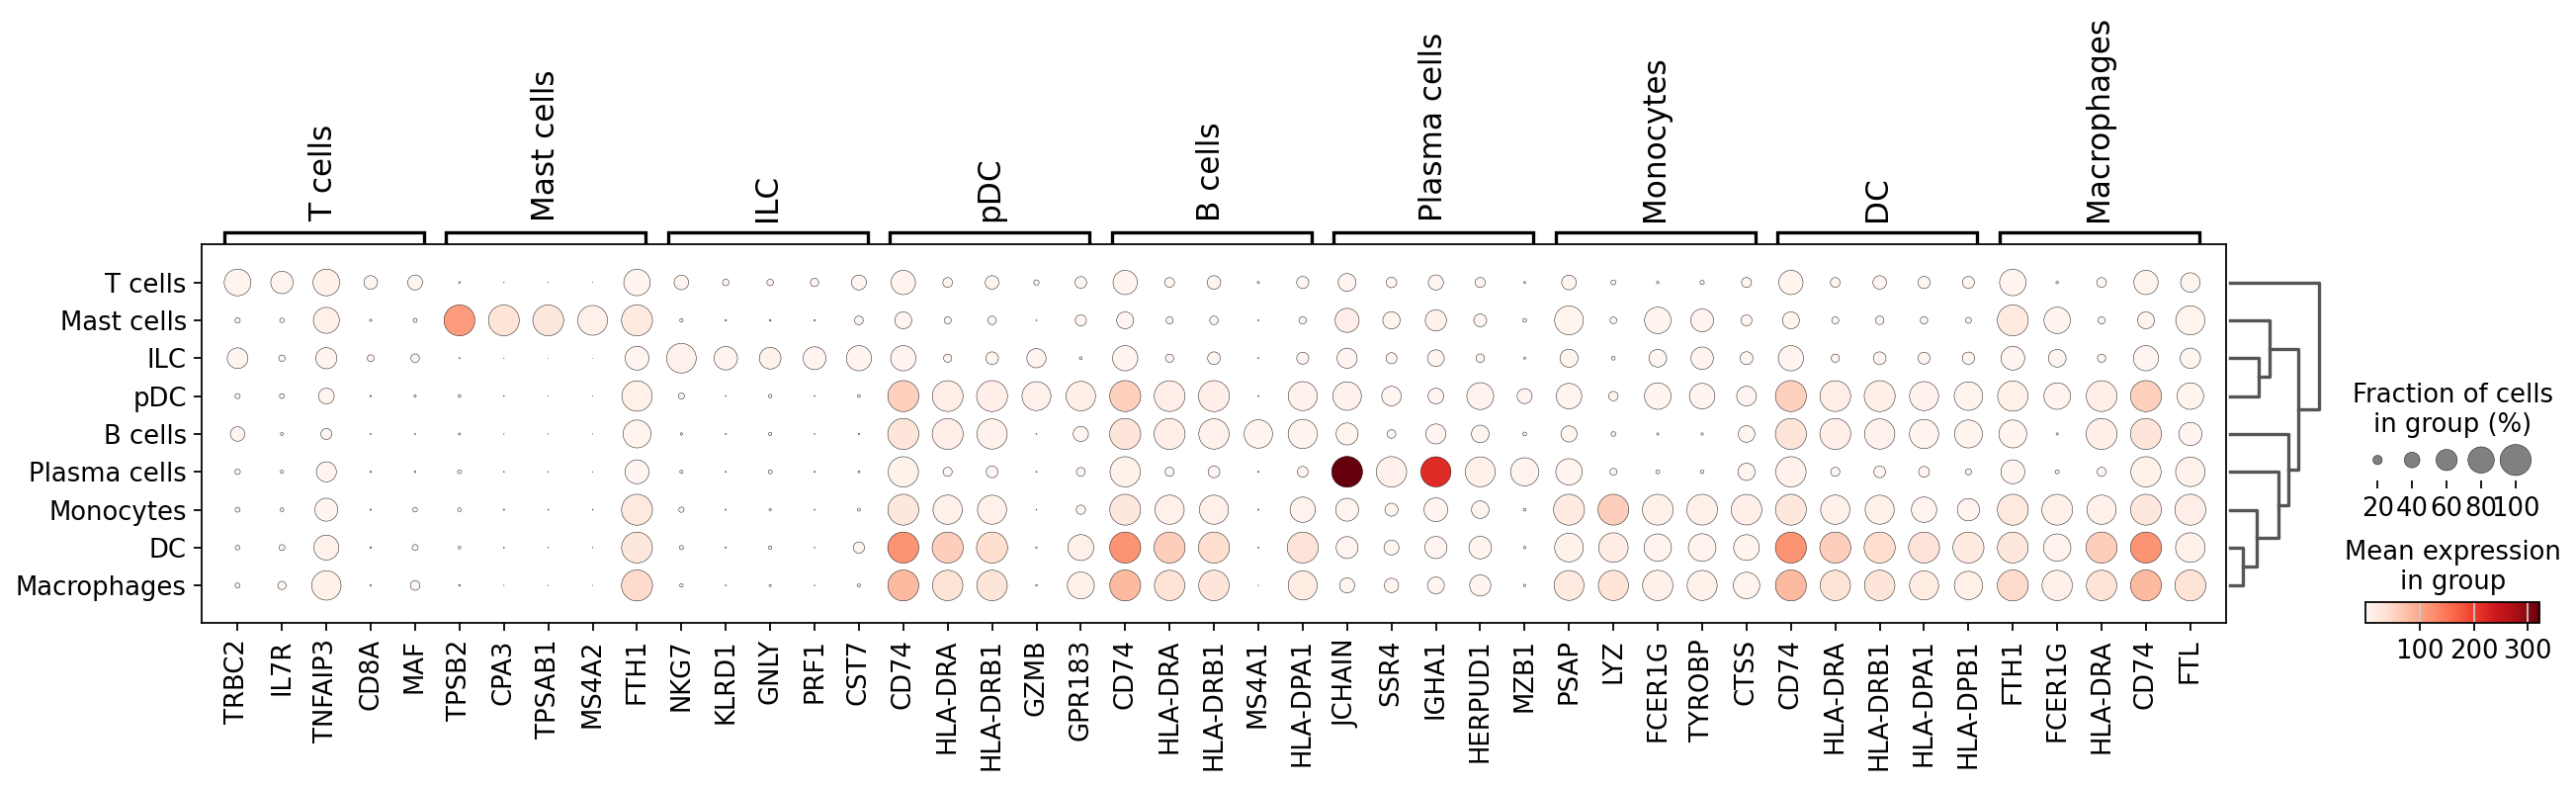

In [13]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=5,
    use_raw=False,
    # vmin=0,
    # vmax=20,
)

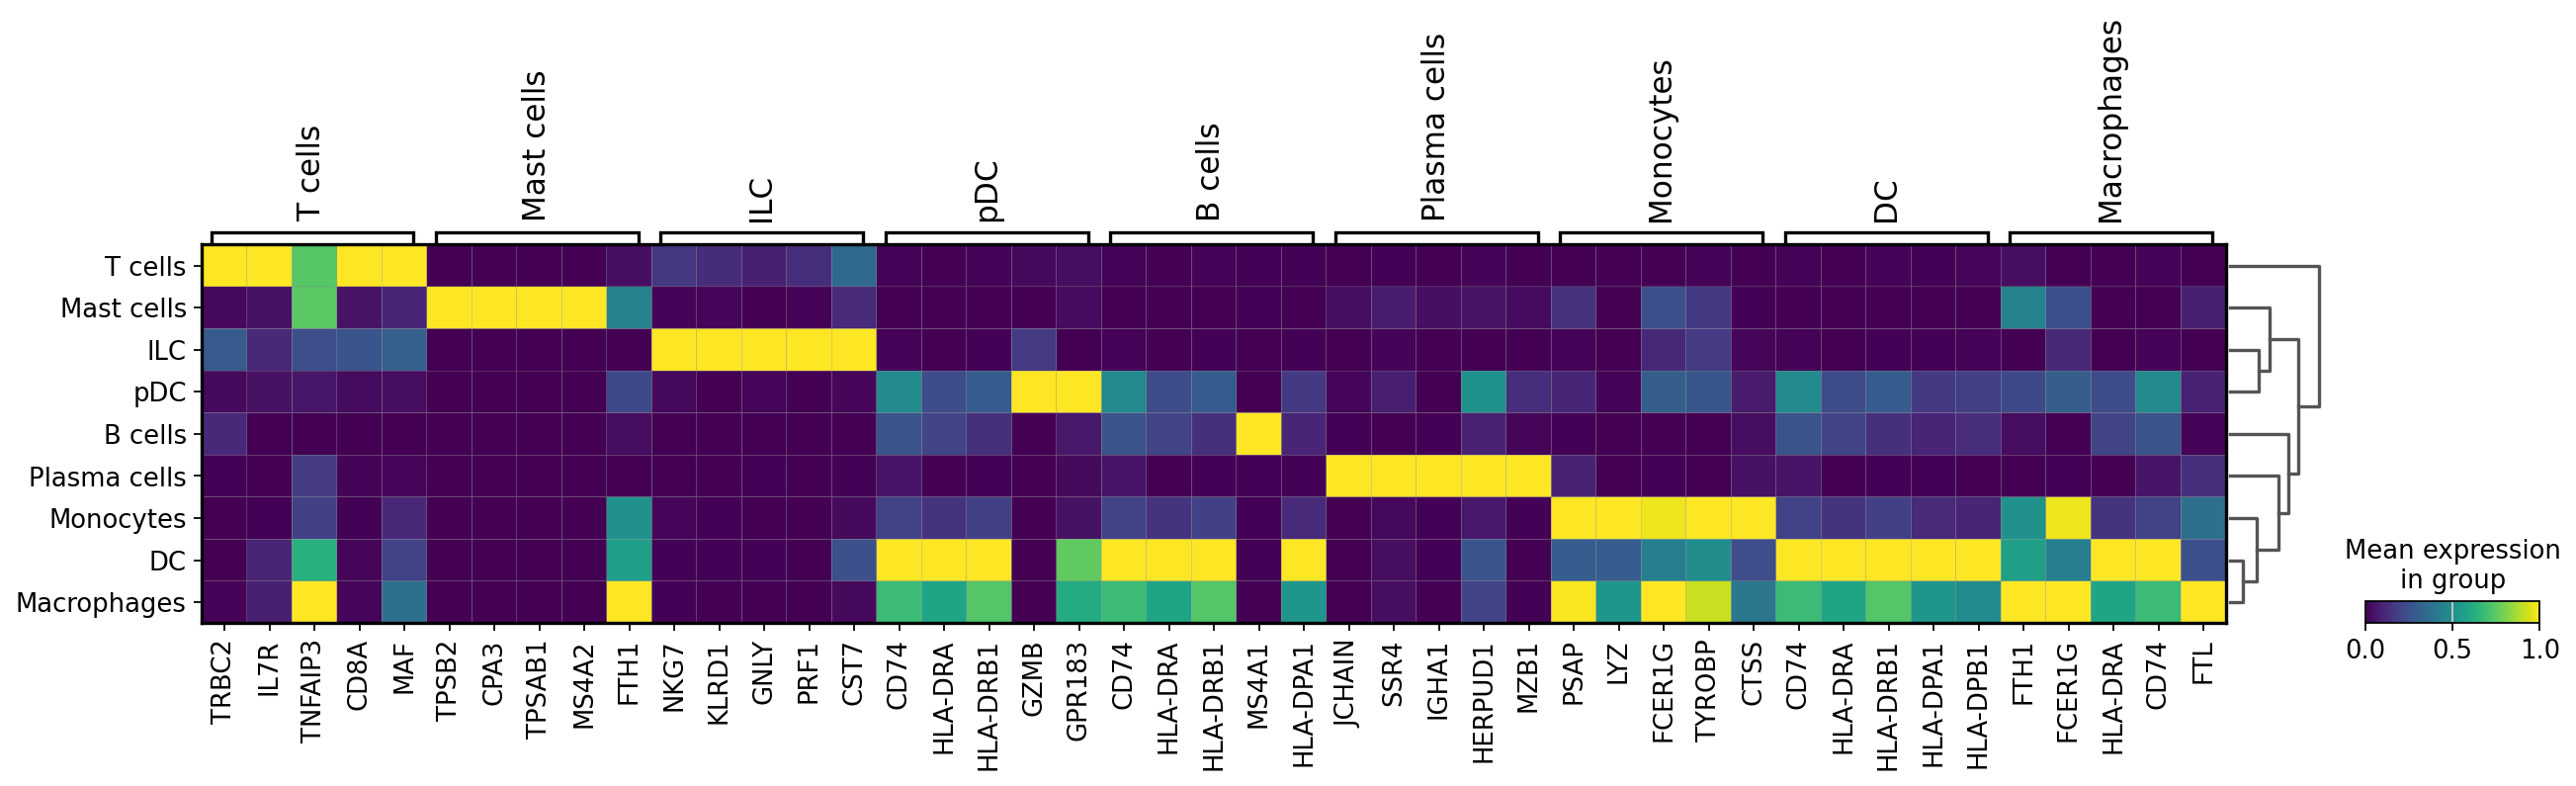

In [14]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=5,
    standard_scale="var",
    use_raw=False,
)

In [15]:
## 过滤
# min_in_group_fraction: 0.25 min_fold_change: 2, max_out_group_fraction: 0.5
# 为了保留 adata.uns['rank_genes_groups'] 的原始结构，过滤基因设置为NaN。
sc.tl.filter_rank_genes_groups(
    adata,
    min_fold_change=2,  # 最小折叠变化阈值
    min_in_group_fraction=0.25,  # 在组内的最小基因表达比例
    max_out_group_fraction=0.5,  # 在组外的最大基因表达比例
    key="rank_genes_groups",  # 基因组数据的键
    key_added="rank_genes_groups_filtered",  # 过滤后的基因组数据的键
    use_raw=False,
)

Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 2, max_out_group_fraction: 0.5


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


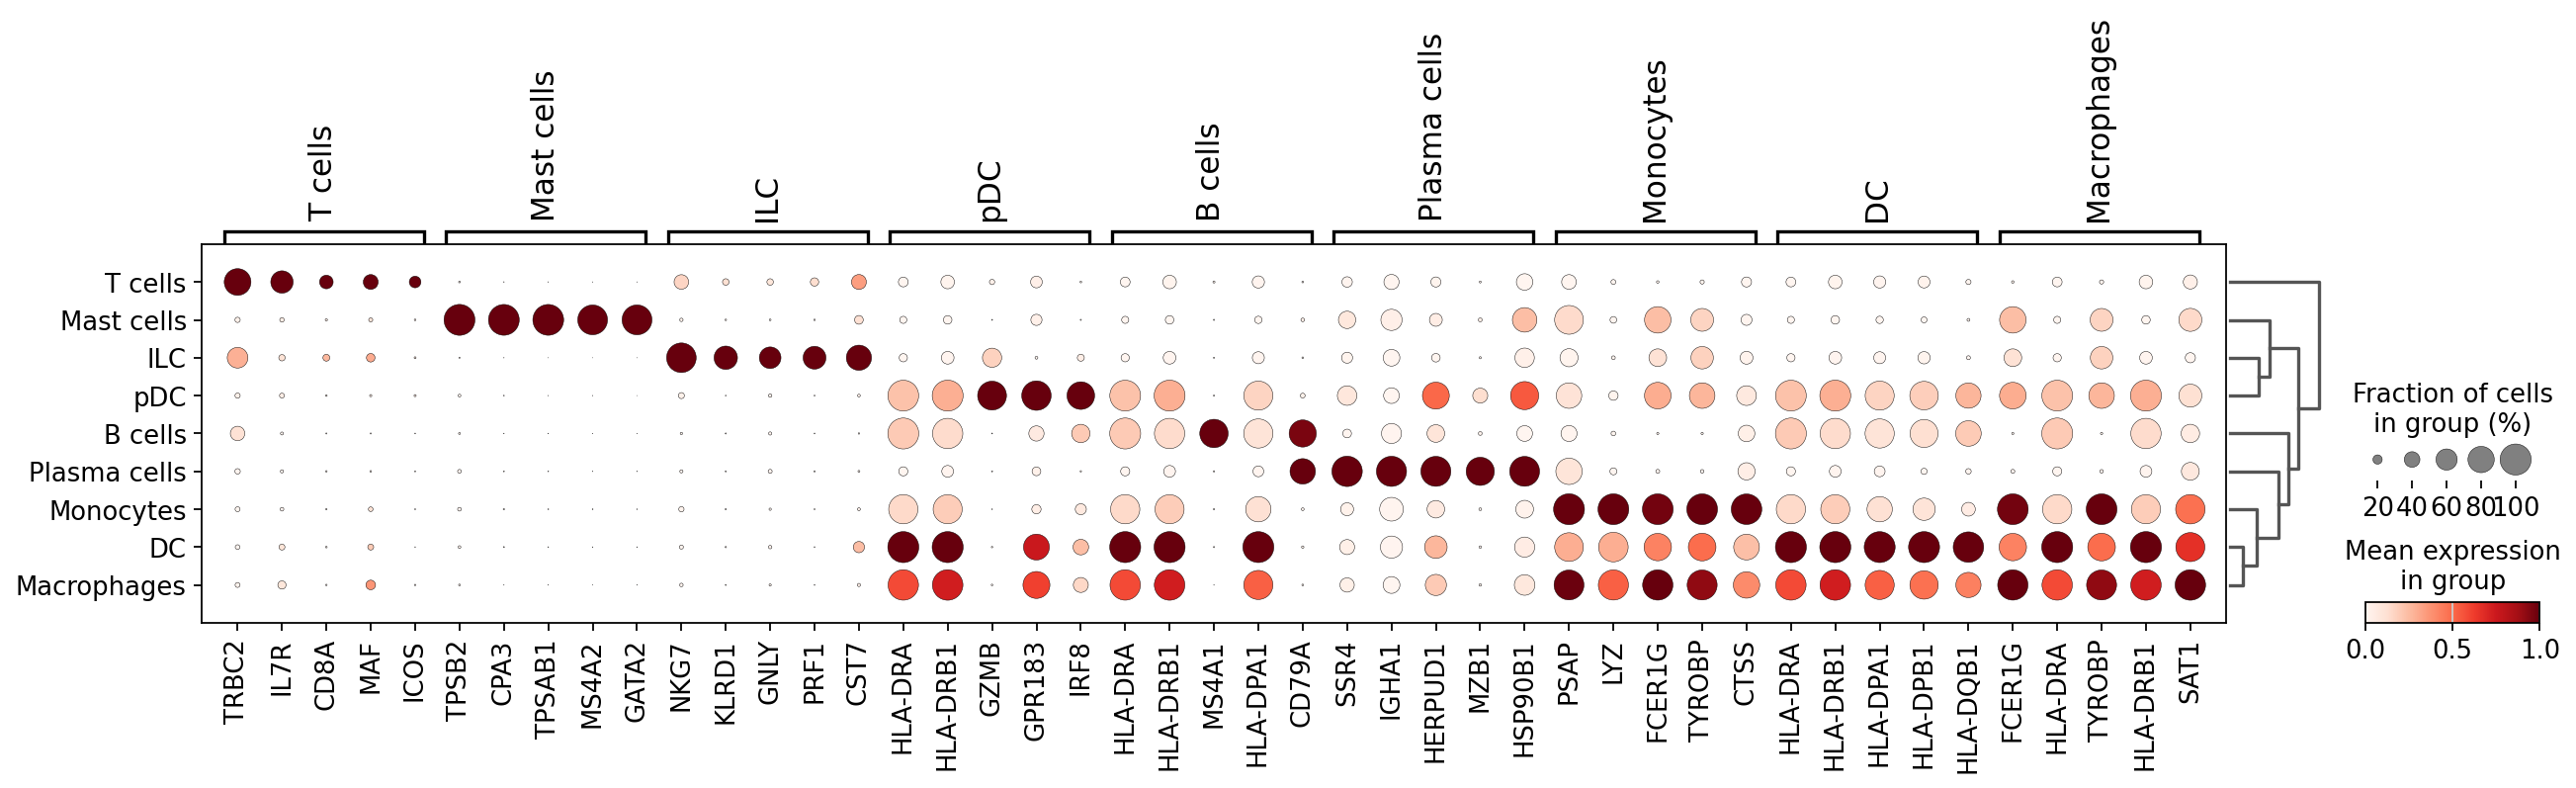

In [16]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby=group_by,
    standard_scale="var",
    n_genes=5,
    key="rank_genes_groups_filtered",
    use_raw=False,
)

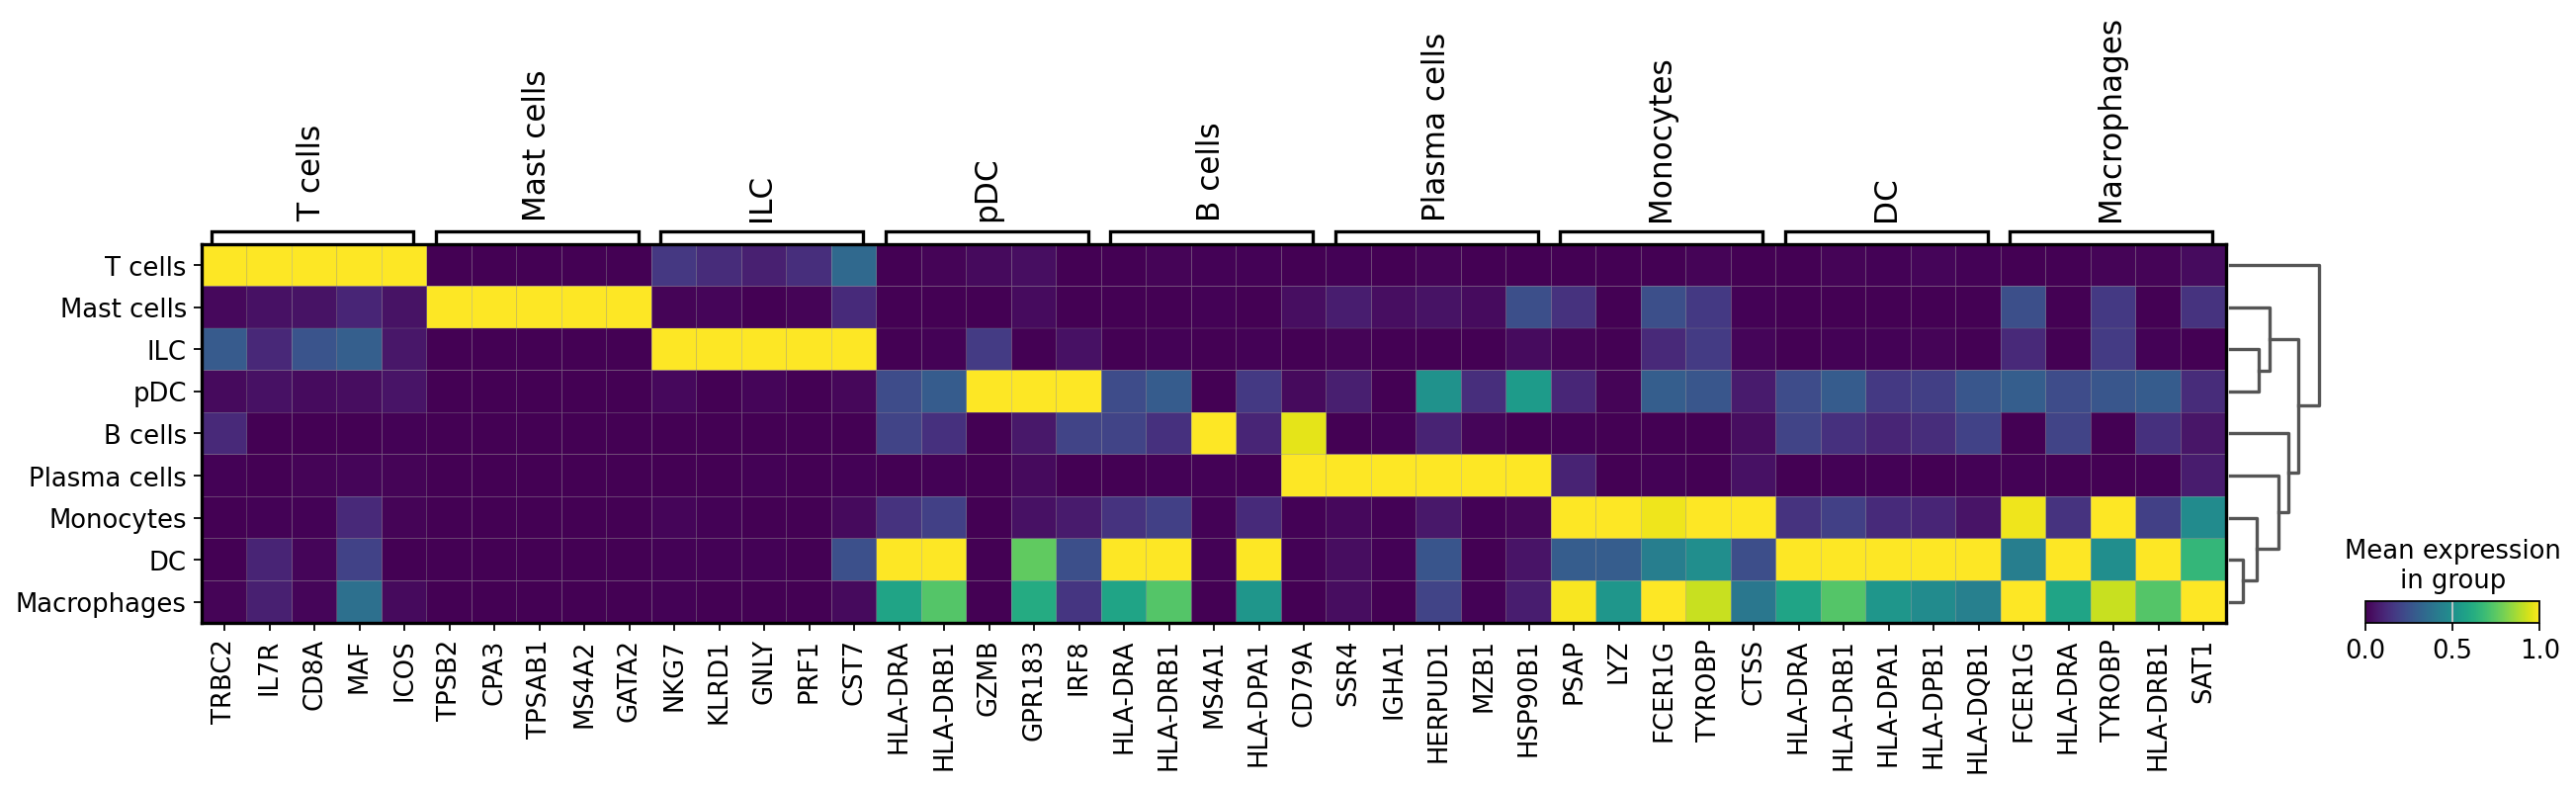

In [17]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=5,
    standard_scale="var",
    key="rank_genes_groups_filtered",
    use_raw=False,
)

In [18]:
##  保存全部maker列表

deg_table = sc.get.rank_genes_groups_df(
    adata,
    group=adata.obs[group_by].unique(),
    key="rank_genes_groups_filtered",
)
deg_table = deg_table.dropna(subset=["names"])
deg_table[:5]
deg_table.to_csv("table/21-all_filtered_rank_genes.csv", index=False)

In [19]:
## 分别保存

for group in adata.obs[group_by].unique():
    rank_genes_df = sc.get.rank_genes_groups_df(
        adata, group=group, key="rank_genes_groups_filtered"
    )
    # 前面的过滤会生成NaN
    rank_genes_df = rank_genes_df.dropna(subset=["names"])

    # 将数据框保存为CSV文件
    rank_genes_df.to_csv(f"table/21-{group}_rank_genes.csv", index=False)

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


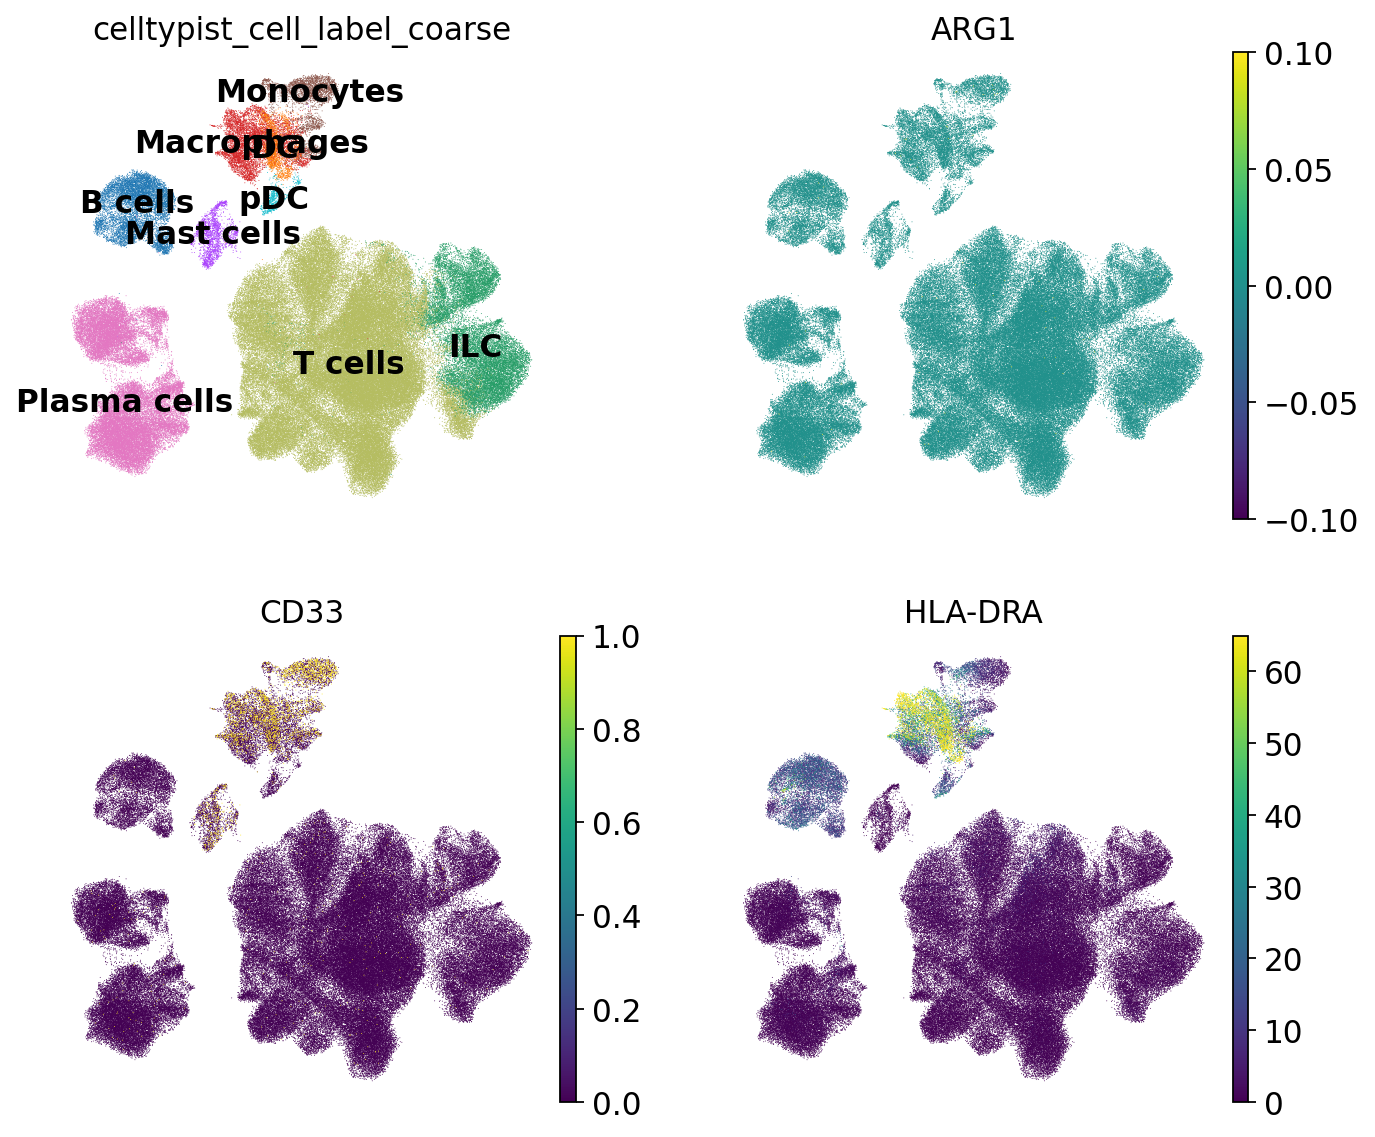

In [20]:
sc.pl.umap(
    adata,
    color=[group_by] + ["ARG1", "CD33", "HLA-DRA"],  # 人类
    legend_loc="on data",
    use_raw=True,  # 默认True就用的是adata.raw.X绘制
    ncols=2,
    vmax="p99",  # 分位数防止极端值影响
    vmin="p10",
)  #

In [21]:
# ## 9.4 肉眼看图注释
# cell_anno = {
#     "0": "MDSCs",
#     "1": "T cells",
#     "2": "Mast cell",
#     "3": "Fibroblasts",
#     "4": "Epithelial cells",
#     "5": "MDSCs",
#     "6": "Monocytes",
#     "7": "Endothelial cells",
# }
# adata.obs["manual_celltype_annotation"] = adata.obs[group_by].map(cell_anno)